In [38]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [39]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [41]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [42]:
def plot(image, target):
    plt.imshow(image, cmap="hot")
    plt.title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'
    plt.show()

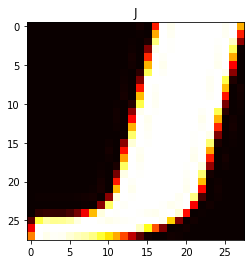

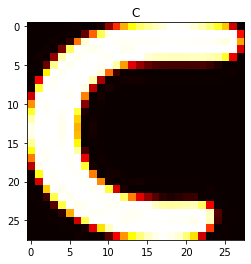

In [43]:
plot(trainData[0], trainTarget[0])
plot(trainData[1], trainTarget[1])

In [44]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

In [45]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w) + b

In [46]:
def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return sum(y_pred == y) / y.shape[0]

# 1 Linear Regression
### 1. Loss Function and Gradient

In [47]:
# Mean Squared Error Loss
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) + reg * w
    b_grad = 2.0/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

# The below is a test for MSE Loss, which is correct (at least without the regulator)
"""
from sklearn.metrics import mean_squared_error

X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

y_pred = predict(w_LS, b_LS, X)
print(mean_squared_error(y, y_pred))
print(MSE(w_LS, b_LS, X, y, 0))
"""

#gradMSE(w, b, X, y, 0.1)



'\nfrom sklearn.metrics import mean_squared_error\n\nX = trainData\ny = trainTarget\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\n\ny_pred = predict(w_LS, b_LS, X)\nprint(mean_squared_error(y, y_pred))\nprint(MSE(w_LS, b_LS, X, y, 0))\n'

# WRITE DOWN ANALYTICAL EXPRESSIONS OF LOSS AND GRADIENT

### 2. Gradient Descent Implementation

In [48]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol, validData=None, validTarget=None, testData=None, testTarget=None):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = True
    for i in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        
        # Calculating Statistics
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if validData != None and validTarget != None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if testData != None and testTarget != None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            valid_acc.append( accuracy(w, b, testData, testTarget) )
        
        # Print Losses and Accurancies if printing is on
        if printing:
            print(f"Training loss: {train_loss[-1]:.4f}\tTraining acc: {train_acc[-1]*100:.2f}%")
            if validData != None and validTarget != None:
                print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
            if testData != None and testTarget != None:
                print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if validData != None and validTarget != None:
        statistics += (valid_loss, valid_acc, )
    if testData != None and testTarget != None:
        statistics += (test_loss, test_acc,)
    # Python 3.8 made this easier, but 3.7 you have to do this
    out = (w, b, *statistics)
    
    return out

X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)
w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 0.005, 5000, 0, 0.001)
#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
train_loss, train_acc = statistics

Training loss: 3501.3294	Training acc: 49.83%
Training loss: 592.1127	Training acc: 50.11%
Training loss: 169.5828	Training acc: 45.94%
Training loss: 99.8934	Training acc: 46.03%
Training loss: 81.6906	Training acc: 46.97%
Training loss: 72.0213	Training acc: 48.40%
Training loss: 64.5385	Training acc: 48.94%
Training loss: 58.1605	Training acc: 49.29%
Training loss: 52.6039	Training acc: 49.77%
Training loss: 47.7289	Training acc: 50.11%
Training loss: 43.4361	Training acc: 50.09%
Training loss: 39.6453	Training acc: 50.51%
Training loss: 36.2896	Training acc: 50.71%
Training loss: 33.3122	Training acc: 51.06%
Training loss: 30.6645	Training acc: 51.86%
Training loss: 28.3049	Training acc: 52.31%
Training loss: 26.1973	Training acc: 52.60%
Training loss: 24.3107	Training acc: 52.89%
Training loss: 22.6182	Training acc: 53.14%
Training loss: 21.0967	Training acc: 53.46%
Training loss: 19.7257	Training acc: 53.54%
Training loss: 18.4878	Training acc: 53.83%
Training loss: 17.3675	Train

Training loss: 1.2461	Training acc: 63.26%
Training loss: 1.2409	Training acc: 63.34%
Training loss: 1.2357	Training acc: 63.29%
Training loss: 1.2306	Training acc: 63.23%
Training loss: 1.2256	Training acc: 63.29%
Training loss: 1.2206	Training acc: 63.29%
Training loss: 1.2157	Training acc: 63.40%
Training loss: 1.2108	Training acc: 63.46%
Training loss: 1.2060	Training acc: 63.43%
Training loss: 1.2012	Training acc: 63.54%
Training loss: 1.1965	Training acc: 63.57%
Training loss: 1.1918	Training acc: 63.63%
Training loss: 1.1872	Training acc: 63.63%
Training loss: 1.1826	Training acc: 63.63%
Training loss: 1.1781	Training acc: 63.66%
Training loss: 1.1737	Training acc: 63.77%
Training loss: 1.1692	Training acc: 63.80%
Training loss: 1.1649	Training acc: 63.91%
Training loss: 1.1606	Training acc: 63.94%
Training loss: 1.1563	Training acc: 63.97%
Training loss: 1.1520	Training acc: 64.03%
Training loss: 1.1479	Training acc: 64.06%
Training loss: 1.1437	Training acc: 64.06%
Training lo

Training loss: 0.7598	Training acc: 67.06%
Training loss: 0.7585	Training acc: 67.06%
Training loss: 0.7572	Training acc: 67.09%
Training loss: 0.7559	Training acc: 67.09%
Training loss: 0.7547	Training acc: 67.09%
Training loss: 0.7534	Training acc: 67.11%
Training loss: 0.7521	Training acc: 67.14%
Training loss: 0.7509	Training acc: 67.09%
Training loss: 0.7496	Training acc: 67.06%
Training loss: 0.7484	Training acc: 67.09%
Training loss: 0.7472	Training acc: 67.09%
Training loss: 0.7459	Training acc: 67.17%
Training loss: 0.7447	Training acc: 67.20%
Training loss: 0.7435	Training acc: 67.20%
Training loss: 0.7423	Training acc: 67.20%
Training loss: 0.7411	Training acc: 67.20%
Training loss: 0.7399	Training acc: 67.23%
Training loss: 0.7387	Training acc: 67.23%
Training loss: 0.7375	Training acc: 67.23%
Training loss: 0.7363	Training acc: 67.17%
Training loss: 0.7351	Training acc: 67.14%
Training loss: 0.7340	Training acc: 67.14%
Training loss: 0.7328	Training acc: 67.20%
Training lo

### 3. Tuning the Learning Rate

In [49]:
# functions to plot loss and accuracy
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None):
    if train_loss != None:
        plt.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        plt.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        plt.plot(x, test_loss, label="Testing Loss")
    
    if title == None:
        plt.title("Training Loss")
    else:
        plt.title(title)
    
    plt.xlabel("Epochs")
    plt.xlim(left=0)
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None):
    if train_accuracy != None:
        plt.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        plt.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        plt.plot(x, test_accuracy, label="Testing Accuracy")
    
    if title == None:
        plt.title("Accuracy")
    else:
        plt.title(title)

    plt.xlabel("Epochs")
    plt.xlim(left=0)
    plt.ylabel("Accuracy")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(linestyle='-', axis='y')
    plt.legend(loc="lower right")
    plt.show()

"""
plot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)
"""

'\nplot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)\nplot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)\n'

In [50]:
# Test your implementation of Gradient Descent with 5000 epochs and \lambda = 0. Investigate the
# impact of learning rate, \alpha = 0.005, 0.001, 0.0001 on the performance of your classifier. 
# Plot the training, validation and test losses.

# Eric

### 4. Generalization

In [51]:
# Investigate impact by modifying the regularization parameter, \lambda = {0.001, 0.1, 0.5}. 
# Plot the training, validation and test loss for \alpha = 0:005 and report the final training, 
# validation and test accuracy of your classifier.

# Sandra

### 5. Comparing Batch GD with normal equation

In [77]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    X, _ = augment(X, np.zeros(X.shape[0]), 0)
    y = y.reshape(-1)
    
    # overparameterized (deep learning)
    if N < d:
        w_aug = X.T.dot(np.linalg.inv( np.dot(X, X.T) )).dot(y)
    # underparameterized (typical case)
    else:
        w_aug = np.linalg.inv( X.T @ X ) @ X.T @ y
    
    return w_aug[1:], w_aug[0]
        
# compare above to gradient descent solution
w_LS, b_LS = least_squares(trainData, trainTarget)

loss = MSE(w_LS, b_LS, trainData, trainTarget, 0)
acc = accuracy(w_LS, b_LS, trainData, trainTarget)
print(f"Least Squares Training loss: {loss:.4f}\tLeast Squares Training acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, validData, validTarget, 0)
acc = accuracy(w_LS, b_LS, validData, validTarget)
print(f"Least Squares Validation loss: {loss:.4f}\tLeast Squares Validation acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, testData, testTarget, 0)
acc = accuracy(w_LS, b_LS, testData, testTarget)
print(f"Least Squares Testing loss: {loss:.4f}\tLeast Squares Testing acc: {100*acc:.2f}%")

Least Squares Training loss: 0.0187	Least Squares Training acc: 71.29%
Least Squares Validation loss: 0.0476	Least Squares Validation acc: 69.00%
Least Squares Testing loss: 0.0570	Least Squares Testing acc: 66.90%


With the analytical solution, the training loss achieved with the analytical equation is 0.0187 with a training accuracy of 71.29%. The training loss and accuracies for batch gradient descent were respectively 0.6918 and 67.97%. From the values, we see that the analytical solution performed better. However, computing it grows increasingly difficult with the size of the problem. As the problem scales, batch gradient descent allows for faster convergence with comparable accuracies.

# 2 Logistic Regression
## 2.1 Binary cross-entropy loss
### 1. Loss Function and Gradient

In [119]:
# this will work for both scalar and vector z
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))
    

# Cross Entropy Loss
def crossEntropyLoss(w, b, X, y, reg):    
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    return 1.0/N * (-y.dot(np.log(y_hat)) - (1 - y).dot(np.log(1 - y_hat))) + reg/2.0 * np.square(w[1:]).sum()
    

def gradCE(w, b, X, y, reg):
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    w_grad = 1.0 /N * X.T.dot(y_hat - y) + reg * w
    
    return w_grad[1:], w_grad[0] - reg * w[0]

# Test that the CE function works
"""
from sklearn.metrics import log_loss

X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

y_pred = sigmoid(predict(w_LS, b_LS, X))
print(log_loss(y, y_pred))
print(crossEntropyLoss(w_LS, b_LS, X, y, 0))
"""

(array([ 3.25451011e-04,  1.91698555e-03,  3.63716001e-03,  5.00023847e-03,
        7.16308206e-03,  9.80929924e-03,  1.19707621e-02,  1.73933573e-02,
        2.24050245e-02,  2.36307173e-02,  2.09730519e-02,  1.71502480e-02,
        1.37823998e-02,  1.37801220e-02,  1.56078414e-02,  2.17949291e-02,
        2.92895164e-02,  4.25105186e-02,  5.87771049e-02,  7.76683341e-02,
        9.92752479e-02,  1.19783461e-01,  1.37429426e-01,  1.50906418e-01,
        1.59073421e-01,  1.63485412e-01,  1.61736345e-01,  1.19725891e-01,
       -2.56086852e-04,  6.55713481e-04,  3.84848380e-04,  3.06845722e-04,
        9.05690811e-04,  1.80468509e-03,  1.06892737e-03, -5.11375626e-03,
       -1.79952098e-02, -3.18295698e-02, -3.82069394e-02, -3.65403817e-02,
       -2.93298005e-02, -1.58783311e-02, -7.27388476e-05,  1.53224250e-02,
        3.11868097e-02,  4.65711511e-02,  5.96690482e-02,  6.99330698e-02,
        7.89289802e-02,  9.00924514e-02,  1.02339152e-01,  1.07710816e-01,
        1.07997689e-01, 

# WRITE DOWN ANALYTICAL EXPRESSIONS OF LOSS AND GRADIENT

$$
\mathcal{L} = \frac{1}{N}\sum_{n=1}^{N} \left [ -y^{(n)} \log( \sigma (W^T\textbf{x}^{(n)} + b)) -(1- y^{(n)}) - \log (1 - \sigma (W^T\textbf{x}^{(n)} + b) ) \right ] + \frac{\lambda}{2} \Vert W \Vert^2_2
$$

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}} = \frac{1}{N}\sum_{n=1}^{N} \left [ -\frac{y^{(n)}}{\sigma (W^T\textbf{x}^{(n)} + b)} + \frac{1- y^{(n)}}{1 - \sigma (W^T\textbf{x}^{(n)} + b)} \right ] \cdot \sigma' (W^T\textbf{x}^{(n)} + b) \cdot 1
$$

$$
\frac{\partial \mathcal{L}}{\partial W} = \frac{1}{N} \sum_{n=1}^{N} \left [ -\frac{y^{(n)}}{\sigma (W^T\textbf{x}^{(n)} + b)} + \frac{1- y^{(n)}}{1 - \sigma (W^T\textbf{x}^{(n)} + b)} \right ] \cdot \sigma' (W^T\textbf{x}^{(n)} + b) \cdot \textbf{x}^{(n)} + \lambda W
$$

### 2. Learning

In [58]:
def grad_descent(w, b, X, y, alpha, epochs, reg, error_tol, lossType="MSE", validData=None, validTarget=None,
                 testData=None, testTarget=None):
    if lossType == "MSE":
        return grad_descent_MSE(W, b, x, y, alpha, epochs, reg, error_tol)
    elif lossType == "CE":
        train_loss, train_acc = [], []
        valid_loss, valid_acc = [], []
        test_loss, test_acc = [], []
        printing = True
        for i in range(epochs):
            grad_w, grad_b = gradCE(w, b, X, y, reg)
            w -= alpha * grad_w
            b -= alpha * grad_b

            # Calculating Statistics
            train_loss.append(crossEntropyLoss(w, b, X, y, reg))
            train_acc.append(accuracy(w, b, X, y))

            if validData is not None and validTarget is not None:
                valid_loss.append(crossEntropyLoss(w, b, validData, validTarget, reg))
                valid_acc.append(accuracy(w, b, validData, validTarget))
            if testData is not None and testTarget is not None:
                test_loss.append(crossEntropyLoss(w, b, testData, testTarget, reg))
                valid_acc.append(accuracy(w, b, testData, testTarget))

            # Print Losses and Accurancies if printing is on
            if printing:
                print(f"Training loss: {train_loss[-1]:.4f}\tTraining acc: {train_acc[-1] * 100:.2f}%")
                if validData is not None and validTarget is not None:
                    print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1] * 100:.2f}%")
                if testData is not None and testTarget is not None:
                    print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1] * 100:.2f}%")

            # Check stopping condition
            if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
                break

        statistics = (train_loss, train_acc)
        if validData is not None and validTarget is not None:
            statistics += (valid_loss, valid_acc,)
        if testData is not None and testTarget is not None:
            statistics += (test_loss, test_acc,)
        out = (w, b, *statistics)

        return out

    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")
        
X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
w = w - w.mean()
b = np.random.random_sample(1)
w, b, *statistics = grad_descent(w, b, trainData, trainTarget, 0.005, 5000, 0.1, 0.0001, lossType="CE")
#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
train_loss, train_acc = statistics

# oops, I (Dev) kinda started doing this one by mistake. All that's left is the plotting of the curves
# Eric

Training loss: 4430.9948	Training acc: 55.71%
Training loss: 4188.5171	Training acc: 56.71%
Training loss: 3969.1121	Training acc: 57.66%
Training loss: 3771.0320	Training acc: 58.97%
Training loss: 3592.4093	Training acc: 59.91%
Training loss: 3431.3624	Training acc: 61.06%
Training loss: 3286.0694	Training acc: 61.71%
Training loss: 3154.8145	Training acc: 62.43%
Training loss: 3036.0136	Training acc: 63.57%
Training loss: 2928.2256	Training acc: 64.40%
Training loss: 2830.1537	Training acc: 65.29%
Training loss: 2740.6414	Training acc: 65.86%
Training loss: 2658.6654	Training acc: 66.83%
Training loss: 2583.3248	Training acc: 67.77%
Training loss: 2513.8313	Training acc: 68.34%
Training loss: 2449.4977	Training acc: 69.37%
Training loss: 2389.7266	Training acc: 70.03%
Training loss: 2334.0002	Training acc: 70.63%
Training loss: 2281.8700	Training acc: 71.46%
Training loss: 2232.9481	Training acc: 72.23%
Training loss: 2186.8987	Training acc: 72.86%
Training loss: 2143.4313	Training 

Training loss: 730.5302	Training acc: 92.06%
Training loss: 728.5576	Training acc: 92.06%
Training loss: 726.6029	Training acc: 92.09%
Training loss: 724.6659	Training acc: 92.06%
Training loss: 722.7463	Training acc: 92.09%
Training loss: 720.8438	Training acc: 92.09%
Training loss: 718.9583	Training acc: 92.11%
Training loss: 717.0894	Training acc: 92.14%
Training loss: 715.2370	Training acc: 92.14%
Training loss: 713.4007	Training acc: 92.17%
Training loss: 711.5804	Training acc: 92.17%
Training loss: 709.7759	Training acc: 92.17%
Training loss: 707.9869	Training acc: 92.17%
Training loss: 706.2132	Training acc: 92.17%
Training loss: 704.4546	Training acc: 92.17%
Training loss: 702.7110	Training acc: 92.17%
Training loss: 700.9820	Training acc: 92.23%
Training loss: 699.2675	Training acc: 92.31%
Training loss: 697.5673	Training acc: 92.31%
Training loss: 695.8812	Training acc: 92.29%
Training loss: 694.2090	Training acc: 92.29%
Training loss: 692.5506	Training acc: 92.29%
Training l

Training loss: 528.3846	Training acc: 94.09%
Training loss: 527.7581	Training acc: 94.09%
Training loss: 527.1343	Training acc: 94.14%
Training loss: 526.5133	Training acc: 94.14%
Training loss: 525.8950	Training acc: 94.14%
Training loss: 525.2793	Training acc: 94.14%
Training loss: 524.6664	Training acc: 94.14%
Training loss: 524.0561	Training acc: 94.14%
Training loss: 523.4484	Training acc: 94.17%
Training loss: 522.8434	Training acc: 94.17%
Training loss: 522.2410	Training acc: 94.17%
Training loss: 521.6411	Training acc: 94.20%
Training loss: 521.0438	Training acc: 94.20%
Training loss: 520.4490	Training acc: 94.20%
Training loss: 519.8568	Training acc: 94.23%
Training loss: 519.2671	Training acc: 94.23%
Training loss: 518.6799	Training acc: 94.23%
Training loss: 518.0951	Training acc: 94.26%
Training loss: 517.5128	Training acc: 94.26%
Training loss: 516.9330	Training acc: 94.26%
Training loss: 516.3555	Training acc: 94.29%
Training loss: 515.7805	Training acc: 94.29%
Training l

Training loss: 445.2087	Training acc: 95.43%
Training loss: 444.8846	Training acc: 95.43%
Training loss: 444.5614	Training acc: 95.43%
Training loss: 444.2392	Training acc: 95.43%
Training loss: 443.9179	Training acc: 95.43%
Training loss: 443.5976	Training acc: 95.43%
Training loss: 443.2782	Training acc: 95.43%
Training loss: 442.9597	Training acc: 95.46%
Training loss: 442.6422	Training acc: 95.46%
Training loss: 442.3255	Training acc: 95.49%
Training loss: 442.0098	Training acc: 95.49%
Training loss: 441.6950	Training acc: 95.49%
Training loss: 441.3811	Training acc: 95.49%
Training loss: 441.0682	Training acc: 95.49%
Training loss: 440.7561	Training acc: 95.49%
Training loss: 440.4449	Training acc: 95.49%
Training loss: 440.1346	Training acc: 95.49%
Training loss: 439.8252	Training acc: 95.49%
Training loss: 439.5167	Training acc: 95.49%
Training loss: 439.2091	Training acc: 95.51%
Training loss: 438.9023	Training acc: 95.51%
Training loss: 438.5965	Training acc: 95.51%
Training l

Training loss: 397.5626	Training acc: 95.94%
Training loss: 397.3628	Training acc: 95.94%
Training loss: 397.1634	Training acc: 95.94%
Training loss: 396.9645	Training acc: 95.94%
Training loss: 396.7661	Training acc: 95.94%
Training loss: 396.5681	Training acc: 95.97%
Training loss: 396.3706	Training acc: 95.97%
Training loss: 396.1735	Training acc: 95.97%
Training loss: 395.9769	Training acc: 95.97%
Training loss: 395.7807	Training acc: 95.97%
Training loss: 395.5850	Training acc: 95.97%
Training loss: 395.3897	Training acc: 95.97%
Training loss: 395.1948	Training acc: 95.97%
Training loss: 395.0004	Training acc: 95.97%
Training loss: 394.8065	Training acc: 96.00%
Training loss: 394.6130	Training acc: 96.00%
Training loss: 394.4199	Training acc: 96.00%
Training loss: 394.2273	Training acc: 96.00%
Training loss: 394.0351	Training acc: 96.00%
Training loss: 393.8433	Training acc: 96.00%
Training loss: 393.6520	Training acc: 96.00%
Training loss: 393.4611	Training acc: 96.00%
Training l

Training loss: 367.1206	Training acc: 96.20%
Training loss: 366.9858	Training acc: 96.20%
Training loss: 366.8512	Training acc: 96.20%
Training loss: 366.7169	Training acc: 96.23%
Training loss: 366.5828	Training acc: 96.23%
Training loss: 366.4490	Training acc: 96.23%
Training loss: 366.3155	Training acc: 96.23%
Training loss: 366.1823	Training acc: 96.23%
Training loss: 366.0493	Training acc: 96.23%
Training loss: 365.9165	Training acc: 96.23%
Training loss: 365.7840	Training acc: 96.23%
Training loss: 365.6518	Training acc: 96.23%
Training loss: 365.5199	Training acc: 96.23%
Training loss: 365.3882	Training acc: 96.26%
Training loss: 365.2567	Training acc: 96.26%
Training loss: 365.1255	Training acc: 96.26%
Training loss: 364.9946	Training acc: 96.26%
Training loss: 364.8639	Training acc: 96.26%
Training loss: 364.7335	Training acc: 96.26%
Training loss: 364.6034	Training acc: 96.26%
Training loss: 364.4735	Training acc: 96.26%
Training loss: 364.3438	Training acc: 96.26%
Training l

Training loss: 345.9813	Training acc: 96.60%
Training loss: 345.8861	Training acc: 96.60%
Training loss: 345.7910	Training acc: 96.60%
Training loss: 345.6961	Training acc: 96.60%
Training loss: 345.6014	Training acc: 96.60%
Training loss: 345.5069	Training acc: 96.60%
Training loss: 345.4125	Training acc: 96.60%
Training loss: 345.3183	Training acc: 96.60%
Training loss: 345.2242	Training acc: 96.60%
Training loss: 345.1303	Training acc: 96.60%
Training loss: 345.0366	Training acc: 96.60%
Training loss: 344.9430	Training acc: 96.60%
Training loss: 344.8496	Training acc: 96.60%
Training loss: 344.7564	Training acc: 96.60%
Training loss: 344.6634	Training acc: 96.60%
Training loss: 344.5705	Training acc: 96.60%
Training loss: 344.4777	Training acc: 96.60%
Training loss: 344.3852	Training acc: 96.63%
Training loss: 344.2928	Training acc: 96.63%
Training loss: 344.2005	Training acc: 96.63%
Training loss: 344.1085	Training acc: 96.63%
Training loss: 344.0165	Training acc: 96.63%
Training l

Training loss: 330.9655	Training acc: 96.83%
Training loss: 330.8960	Training acc: 96.83%
Training loss: 330.8266	Training acc: 96.83%
Training loss: 330.7573	Training acc: 96.83%
Training loss: 330.6881	Training acc: 96.83%
Training loss: 330.6190	Training acc: 96.83%
Training loss: 330.5501	Training acc: 96.83%
Training loss: 330.4813	Training acc: 96.86%
Training loss: 330.4126	Training acc: 96.86%
Training loss: 330.3440	Training acc: 96.86%
Training loss: 330.2755	Training acc: 96.86%
Training loss: 330.2071	Training acc: 96.86%
Training loss: 330.1388	Training acc: 96.86%
Training loss: 330.0707	Training acc: 96.86%
Training loss: 330.0026	Training acc: 96.86%
Training loss: 329.9347	Training acc: 96.86%
Training loss: 329.8669	Training acc: 96.86%
Training loss: 329.7992	Training acc: 96.86%
Training loss: 329.7316	Training acc: 96.86%
Training loss: 329.6641	Training acc: 96.86%
Training loss: 329.5967	Training acc: 96.86%
Training loss: 329.5294	Training acc: 96.86%
Training l

Training loss: 319.9455	Training acc: 97.20%
Training loss: 319.8936	Training acc: 97.20%
Training loss: 319.8418	Training acc: 97.20%
Training loss: 319.7901	Training acc: 97.20%
Training loss: 319.7385	Training acc: 97.20%
Training loss: 319.6870	Training acc: 97.20%
Training loss: 319.6355	Training acc: 97.20%
Training loss: 319.5841	Training acc: 97.20%
Training loss: 319.5328	Training acc: 97.20%
Training loss: 319.4816	Training acc: 97.20%
Training loss: 319.4305	Training acc: 97.20%
Training loss: 319.3794	Training acc: 97.20%
Training loss: 319.3285	Training acc: 97.20%
Training loss: 319.2776	Training acc: 97.20%
Training loss: 319.2267	Training acc: 97.20%
Training loss: 319.1760	Training acc: 97.20%
Training loss: 319.1253	Training acc: 97.20%
Training loss: 319.0747	Training acc: 97.20%
Training loss: 319.0242	Training acc: 97.20%
Training loss: 318.9738	Training acc: 97.20%
Training loss: 318.9235	Training acc: 97.20%
Training loss: 318.8732	Training acc: 97.20%
Training l

Training loss: 311.5845	Training acc: 97.31%
Training loss: 311.5453	Training acc: 97.34%
Training loss: 311.5062	Training acc: 97.34%
Training loss: 311.4671	Training acc: 97.34%
Training loss: 311.4282	Training acc: 97.34%
Training loss: 311.3892	Training acc: 97.34%
Training loss: 311.3504	Training acc: 97.34%
Training loss: 311.3115	Training acc: 97.34%
Training loss: 311.2728	Training acc: 97.34%
Training loss: 311.2341	Training acc: 97.34%
Training loss: 311.1954	Training acc: 97.34%
Training loss: 311.1569	Training acc: 97.34%
Training loss: 311.1183	Training acc: 97.34%
Training loss: 311.0799	Training acc: 97.34%
Training loss: 311.0414	Training acc: 97.34%
Training loss: 311.0031	Training acc: 97.34%
Training loss: 310.9648	Training acc: 97.34%
Training loss: 310.9265	Training acc: 97.34%
Training loss: 310.8883	Training acc: 97.34%
Training loss: 310.8502	Training acc: 97.34%
Training loss: 310.8121	Training acc: 97.34%
Training loss: 310.7741	Training acc: 97.34%
Training l

Training loss: 305.2607	Training acc: 97.40%
Training loss: 305.2307	Training acc: 97.40%
Training loss: 305.2007	Training acc: 97.40%
Training loss: 305.1708	Training acc: 97.40%
Training loss: 305.1410	Training acc: 97.40%
Training loss: 305.1111	Training acc: 97.40%
Training loss: 305.0813	Training acc: 97.40%
Training loss: 305.0516	Training acc: 97.40%
Training loss: 305.0219	Training acc: 97.40%
Training loss: 304.9922	Training acc: 97.40%
Training loss: 304.9626	Training acc: 97.40%
Training loss: 304.9330	Training acc: 97.40%
Training loss: 304.9035	Training acc: 97.40%
Training loss: 304.8740	Training acc: 97.40%
Training loss: 304.8445	Training acc: 97.43%
Training loss: 304.8151	Training acc: 97.43%
Training loss: 304.7857	Training acc: 97.43%
Training loss: 304.7564	Training acc: 97.40%
Training loss: 304.7271	Training acc: 97.40%
Training loss: 304.6979	Training acc: 97.40%
Training loss: 304.6687	Training acc: 97.43%
Training loss: 304.6395	Training acc: 97.43%
Training l

Training loss: 300.3657	Training acc: 97.49%
Training loss: 300.3425	Training acc: 97.49%
Training loss: 300.3193	Training acc: 97.49%
Training loss: 300.2962	Training acc: 97.49%
Training loss: 300.2730	Training acc: 97.49%
Training loss: 300.2499	Training acc: 97.49%
Training loss: 300.2269	Training acc: 97.49%
Training loss: 300.2039	Training acc: 97.49%
Training loss: 300.1809	Training acc: 97.49%
Training loss: 300.1579	Training acc: 97.49%
Training loss: 300.1349	Training acc: 97.49%
Training loss: 300.1120	Training acc: 97.49%
Training loss: 300.0892	Training acc: 97.49%
Training loss: 300.0663	Training acc: 97.49%
Training loss: 300.0435	Training acc: 97.49%
Training loss: 300.0207	Training acc: 97.49%
Training loss: 299.9980	Training acc: 97.49%
Training loss: 299.9752	Training acc: 97.49%
Training loss: 299.9525	Training acc: 97.49%
Training loss: 299.9299	Training acc: 97.49%
Training loss: 299.9072	Training acc: 97.49%
Training loss: 299.8846	Training acc: 97.49%
Training l

Training loss: 296.5384	Training acc: 97.66%
Training loss: 296.5202	Training acc: 97.66%
Training loss: 296.5021	Training acc: 97.66%
Training loss: 296.4840	Training acc: 97.66%
Training loss: 296.4659	Training acc: 97.66%
Training loss: 296.4479	Training acc: 97.66%
Training loss: 296.4298	Training acc: 97.66%
Training loss: 296.4118	Training acc: 97.66%
Training loss: 296.3938	Training acc: 97.66%
Training loss: 296.3758	Training acc: 97.69%
Training loss: 296.3579	Training acc: 97.69%
Training loss: 296.3400	Training acc: 97.69%
Training loss: 296.3221	Training acc: 97.69%
Training loss: 296.3042	Training acc: 97.69%
Training loss: 296.2864	Training acc: 97.69%
Training loss: 296.2685	Training acc: 97.69%
Training loss: 296.2507	Training acc: 97.69%
Training loss: 296.2330	Training acc: 97.69%
Training loss: 296.2152	Training acc: 97.69%
Training loss: 296.1975	Training acc: 97.69%
Training loss: 296.1797	Training acc: 97.69%
Training loss: 296.1621	Training acc: 97.69%
Training l

Training loss: 293.5734	Training acc: 97.71%
Training loss: 293.5590	Training acc: 97.71%
Training loss: 293.5446	Training acc: 97.71%
Training loss: 293.5302	Training acc: 97.71%
Training loss: 293.5159	Training acc: 97.71%
Training loss: 293.5015	Training acc: 97.71%
Training loss: 293.4872	Training acc: 97.71%
Training loss: 293.4729	Training acc: 97.71%
Training loss: 293.4586	Training acc: 97.71%
Training loss: 293.4444	Training acc: 97.71%
Training loss: 293.4301	Training acc: 97.71%
Training loss: 293.4159	Training acc: 97.71%
Training loss: 293.4017	Training acc: 97.71%
Training loss: 293.3875	Training acc: 97.71%
Training loss: 293.3733	Training acc: 97.71%
Training loss: 293.3591	Training acc: 97.71%
Training loss: 293.3450	Training acc: 97.71%
Training loss: 293.3309	Training acc: 97.71%
Training loss: 293.3168	Training acc: 97.71%
Training loss: 293.3027	Training acc: 97.71%
Training loss: 293.2886	Training acc: 97.71%
Training loss: 293.2746	Training acc: 97.71%
Training l

Training loss: 291.2083	Training acc: 97.77%
Training loss: 291.1968	Training acc: 97.77%
Training loss: 291.1852	Training acc: 97.77%
Training loss: 291.1737	Training acc: 97.77%
Training loss: 291.1622	Training acc: 97.77%
Training loss: 291.1507	Training acc: 97.77%
Training loss: 291.1392	Training acc: 97.77%
Training loss: 291.1277	Training acc: 97.77%
Training loss: 291.1163	Training acc: 97.77%
Training loss: 291.1048	Training acc: 97.77%
Training loss: 291.0934	Training acc: 97.77%
Training loss: 291.0820	Training acc: 97.77%
Training loss: 291.0706	Training acc: 97.77%
Training loss: 291.0592	Training acc: 97.77%
Training loss: 291.0478	Training acc: 97.77%
Training loss: 291.0364	Training acc: 97.77%
Training loss: 291.0251	Training acc: 97.77%
Training loss: 291.0137	Training acc: 97.77%
Training loss: 291.0024	Training acc: 97.77%
Training loss: 290.9911	Training acc: 97.77%
Training loss: 290.9798	Training acc: 97.77%
Training loss: 290.9685	Training acc: 97.77%
Training l

Training loss: 289.2734	Training acc: 97.80%
Training loss: 289.2641	Training acc: 97.80%
Training loss: 289.2548	Training acc: 97.80%
Training loss: 289.2455	Training acc: 97.80%
Training loss: 289.2362	Training acc: 97.80%
Training loss: 289.2269	Training acc: 97.80%
Training loss: 289.2176	Training acc: 97.80%
Training loss: 289.2083	Training acc: 97.80%
Training loss: 289.1990	Training acc: 97.80%
Training loss: 289.1898	Training acc: 97.80%
Training loss: 289.1805	Training acc: 97.80%
Training loss: 289.1713	Training acc: 97.80%
Training loss: 289.1621	Training acc: 97.80%
Training loss: 289.1529	Training acc: 97.80%
Training loss: 289.1437	Training acc: 97.80%
Training loss: 289.1345	Training acc: 97.80%
Training loss: 289.1253	Training acc: 97.80%
Training loss: 289.1161	Training acc: 97.83%
Training loss: 289.1070	Training acc: 97.83%
Training loss: 289.0978	Training acc: 97.83%
Training loss: 289.0887	Training acc: 97.83%
Training loss: 289.0795	Training acc: 97.83%
Training l

Training loss: 287.7018	Training acc: 97.83%
Training loss: 287.6942	Training acc: 97.83%
Training loss: 287.6866	Training acc: 97.83%
Training loss: 287.6790	Training acc: 97.83%
Training loss: 287.6714	Training acc: 97.83%
Training loss: 287.6638	Training acc: 97.83%
Training loss: 287.6562	Training acc: 97.83%
Training loss: 287.6486	Training acc: 97.83%
Training loss: 287.6410	Training acc: 97.83%
Training loss: 287.6335	Training acc: 97.83%
Training loss: 287.6259	Training acc: 97.83%
Training loss: 287.6184	Training acc: 97.83%
Training loss: 287.6108	Training acc: 97.83%
Training loss: 287.6033	Training acc: 97.83%
Training loss: 287.5958	Training acc: 97.83%
Training loss: 287.5883	Training acc: 97.83%
Training loss: 287.5808	Training acc: 97.83%
Training loss: 287.5733	Training acc: 97.83%
Training loss: 287.5658	Training acc: 97.83%
Training loss: 287.5583	Training acc: 97.83%
Training loss: 287.5508	Training acc: 97.83%
Training loss: 287.5433	Training acc: 97.83%
Training l

Training loss: 286.4053	Training acc: 97.83%
Training loss: 286.3990	Training acc: 97.83%
Training loss: 286.3927	Training acc: 97.83%
Training loss: 286.3864	Training acc: 97.83%
Training loss: 286.3802	Training acc: 97.80%
Training loss: 286.3739	Training acc: 97.80%
Training loss: 286.3676	Training acc: 97.80%
Training loss: 286.3614	Training acc: 97.80%
Training loss: 286.3551	Training acc: 97.80%
Training loss: 286.3489	Training acc: 97.80%
Training loss: 286.3427	Training acc: 97.77%
Training loss: 286.3364	Training acc: 97.77%
Training loss: 286.3302	Training acc: 97.77%
Training loss: 286.3240	Training acc: 97.77%
Training loss: 286.3178	Training acc: 97.77%
Training loss: 286.3116	Training acc: 97.77%
Training loss: 286.3054	Training acc: 97.77%
Training loss: 286.2992	Training acc: 97.77%
Training loss: 286.2930	Training acc: 97.77%
Training loss: 286.2869	Training acc: 97.77%
Training loss: 286.2807	Training acc: 97.80%
Training loss: 286.2745	Training acc: 97.80%
Training l

Training loss: 285.3466	Training acc: 97.83%
Training loss: 285.3413	Training acc: 97.83%
Training loss: 285.3361	Training acc: 97.83%
Training loss: 285.3309	Training acc: 97.83%
Training loss: 285.3256	Training acc: 97.83%
Training loss: 285.3204	Training acc: 97.83%
Training loss: 285.3152	Training acc: 97.83%
Training loss: 285.3099	Training acc: 97.83%
Training loss: 285.3047	Training acc: 97.83%
Training loss: 285.2995	Training acc: 97.83%
Training loss: 285.2943	Training acc: 97.83%
Training loss: 285.2891	Training acc: 97.83%
Training loss: 285.2839	Training acc: 97.83%
Training loss: 285.2787	Training acc: 97.83%
Training loss: 285.2735	Training acc: 97.83%
Training loss: 285.2683	Training acc: 97.83%
Training loss: 285.2631	Training acc: 97.83%
Training loss: 285.2580	Training acc: 97.83%
Training loss: 285.2528	Training acc: 97.83%
Training loss: 285.2476	Training acc: 97.83%
Training loss: 285.2425	Training acc: 97.83%
Training loss: 285.2373	Training acc: 97.83%
Training l

Training loss: 284.4448	Training acc: 97.91%
Training loss: 284.4404	Training acc: 97.91%
Training loss: 284.4360	Training acc: 97.91%
Training loss: 284.4316	Training acc: 97.91%
Training loss: 284.4272	Training acc: 97.91%
Training loss: 284.4228	Training acc: 97.91%
Training loss: 284.4184	Training acc: 97.91%
Training loss: 284.4140	Training acc: 97.91%
Training loss: 284.4096	Training acc: 97.91%
Training loss: 284.4052	Training acc: 97.91%
Training loss: 284.4008	Training acc: 97.91%
Training loss: 284.3964	Training acc: 97.91%
Training loss: 284.3921	Training acc: 97.91%
Training loss: 284.3877	Training acc: 97.91%
Training loss: 284.3833	Training acc: 97.91%
Training loss: 284.3790	Training acc: 97.91%
Training loss: 284.3746	Training acc: 97.91%
Training loss: 284.3702	Training acc: 97.91%
Training loss: 284.3659	Training acc: 97.91%
Training loss: 284.3615	Training acc: 97.91%
Training loss: 284.3572	Training acc: 97.91%
Training loss: 284.3529	Training acc: 97.91%
Training l

Training loss: 283.6941	Training acc: 97.91%
Training loss: 283.6904	Training acc: 97.91%
Training loss: 283.6866	Training acc: 97.91%
Training loss: 283.6829	Training acc: 97.91%
Training loss: 283.6791	Training acc: 97.91%
Training loss: 283.6754	Training acc: 97.91%
Training loss: 283.6716	Training acc: 97.91%
Training loss: 283.6679	Training acc: 97.91%
Training loss: 283.6641	Training acc: 97.91%
Training loss: 283.6604	Training acc: 97.91%
Training loss: 283.6567	Training acc: 97.91%
Training loss: 283.6530	Training acc: 97.91%
Training loss: 283.6492	Training acc: 97.91%
Training loss: 283.6455	Training acc: 97.91%
Training loss: 283.6418	Training acc: 97.91%
Training loss: 283.6381	Training acc: 97.91%
Training loss: 283.6344	Training acc: 97.91%
Training loss: 283.6306	Training acc: 97.91%
Training loss: 283.6269	Training acc: 97.91%
Training loss: 283.6232	Training acc: 97.91%
Training loss: 283.6195	Training acc: 97.91%
Training loss: 283.6158	Training acc: 97.91%
Training l

Training loss: 283.0557	Training acc: 97.97%
Training loss: 283.0525	Training acc: 97.97%
Training loss: 283.0493	Training acc: 97.97%
Training loss: 283.0461	Training acc: 97.97%
Training loss: 283.0428	Training acc: 97.97%
Training loss: 283.0396	Training acc: 97.97%
Training loss: 283.0364	Training acc: 97.97%
Training loss: 283.0332	Training acc: 97.97%
Training loss: 283.0300	Training acc: 97.97%
Training loss: 283.0267	Training acc: 97.97%
Training loss: 283.0235	Training acc: 97.97%
Training loss: 283.0203	Training acc: 97.97%
Training loss: 283.0171	Training acc: 97.97%
Training loss: 283.0139	Training acc: 97.97%
Training loss: 283.0107	Training acc: 97.97%
Training loss: 283.0075	Training acc: 97.97%
Training loss: 283.0043	Training acc: 97.97%
Training loss: 283.0012	Training acc: 97.97%
Training loss: 282.9980	Training acc: 97.97%
Training loss: 282.9948	Training acc: 97.97%
Training loss: 282.9916	Training acc: 97.97%
Training loss: 282.9884	Training acc: 97.97%
Training l

Training loss: 282.5050	Training acc: 98.03%
Training loss: 282.5022	Training acc: 98.03%
Training loss: 282.4994	Training acc: 98.03%
Training loss: 282.4966	Training acc: 98.03%
Training loss: 282.4938	Training acc: 98.03%
Training loss: 282.4910	Training acc: 98.03%
Training loss: 282.4882	Training acc: 98.03%
Training loss: 282.4854	Training acc: 98.03%
Training loss: 282.4826	Training acc: 98.03%
Training loss: 282.4799	Training acc: 98.03%
Training loss: 282.4771	Training acc: 98.03%
Training loss: 282.4743	Training acc: 98.03%
Training loss: 282.4715	Training acc: 98.03%
Training loss: 282.4688	Training acc: 98.03%
Training loss: 282.4660	Training acc: 98.03%
Training loss: 282.4632	Training acc: 98.03%
Training loss: 282.4604	Training acc: 98.03%
Training loss: 282.4577	Training acc: 98.03%
Training loss: 282.4549	Training acc: 98.03%
Training loss: 282.4522	Training acc: 98.03%
Training loss: 282.4494	Training acc: 98.03%
Training loss: 282.4466	Training acc: 98.03%
Training l

Training loss: 282.0260	Training acc: 98.06%
Training loss: 282.0236	Training acc: 98.06%
Training loss: 282.0211	Training acc: 98.06%
Training loss: 282.0187	Training acc: 98.06%
Training loss: 282.0162	Training acc: 98.06%
Training loss: 282.0138	Training acc: 98.06%
Training loss: 282.0114	Training acc: 98.06%
Training loss: 282.0089	Training acc: 98.06%
Training loss: 282.0065	Training acc: 98.06%
Training loss: 282.0041	Training acc: 98.06%
Training loss: 282.0016	Training acc: 98.06%
Training loss: 281.9992	Training acc: 98.06%
Training loss: 281.9968	Training acc: 98.06%
Training loss: 281.9944	Training acc: 98.06%
Training loss: 281.9919	Training acc: 98.06%
Training loss: 281.9895	Training acc: 98.06%
Training loss: 281.9871	Training acc: 98.06%
Training loss: 281.9847	Training acc: 98.06%
Training loss: 281.9823	Training acc: 98.06%
Training loss: 281.9799	Training acc: 98.06%
Training loss: 281.9775	Training acc: 98.06%
Training loss: 281.9750	Training acc: 98.06%
Training l

Training loss: 281.5976	Training acc: 98.06%
Training loss: 281.5955	Training acc: 98.06%
Training loss: 281.5933	Training acc: 98.06%
Training loss: 281.5912	Training acc: 98.06%
Training loss: 281.5891	Training acc: 98.06%
Training loss: 281.5869	Training acc: 98.06%
Training loss: 281.5848	Training acc: 98.06%
Training loss: 281.5827	Training acc: 98.06%
Training loss: 281.5805	Training acc: 98.06%
Training loss: 281.5784	Training acc: 98.06%
Training loss: 281.5763	Training acc: 98.06%
Training loss: 281.5741	Training acc: 98.06%
Training loss: 281.5720	Training acc: 98.06%
Training loss: 281.5699	Training acc: 98.06%
Training loss: 281.5677	Training acc: 98.06%
Training loss: 281.5656	Training acc: 98.06%
Training loss: 281.5635	Training acc: 98.06%
Training loss: 281.5614	Training acc: 98.06%
Training loss: 281.5592	Training acc: 98.03%
Training loss: 281.5571	Training acc: 98.03%
Training loss: 281.5550	Training acc: 98.03%
Training loss: 281.5529	Training acc: 98.03%
Training l

Training loss: 281.2242	Training acc: 98.03%
Training loss: 281.2223	Training acc: 98.03%
Training loss: 281.2204	Training acc: 98.03%
Training loss: 281.2185	Training acc: 98.03%
Training loss: 281.2166	Training acc: 98.03%
Training loss: 281.2147	Training acc: 98.03%
Training loss: 281.2128	Training acc: 98.03%
Training loss: 281.2109	Training acc: 98.03%
Training loss: 281.2090	Training acc: 98.03%
Training loss: 281.2071	Training acc: 98.03%
Training loss: 281.2052	Training acc: 98.03%
Training loss: 281.2033	Training acc: 98.03%
Training loss: 281.2015	Training acc: 98.03%
Training loss: 281.1996	Training acc: 98.03%
Training loss: 281.1977	Training acc: 98.03%
Training loss: 281.1958	Training acc: 98.03%
Training loss: 281.1939	Training acc: 98.03%
Training loss: 281.1921	Training acc: 98.03%
Training loss: 281.1902	Training acc: 98.03%
Training loss: 281.1883	Training acc: 98.03%
Training loss: 281.1864	Training acc: 98.03%
Training loss: 281.1845	Training acc: 98.03%
Training l

Training loss: 280.8958	Training acc: 98.06%
Training loss: 280.8941	Training acc: 98.06%
Training loss: 280.8924	Training acc: 98.06%
Training loss: 280.8907	Training acc: 98.06%
Training loss: 280.8890	Training acc: 98.06%
Training loss: 280.8873	Training acc: 98.06%
Training loss: 280.8856	Training acc: 98.06%
Training loss: 280.8840	Training acc: 98.06%
Training loss: 280.8823	Training acc: 98.06%
Training loss: 280.8806	Training acc: 98.06%
Training loss: 280.8789	Training acc: 98.06%
Training loss: 280.8772	Training acc: 98.06%
Training loss: 280.8755	Training acc: 98.06%
Training loss: 280.8738	Training acc: 98.06%
Training loss: 280.8722	Training acc: 98.06%
Training loss: 280.8705	Training acc: 98.06%
Training loss: 280.8688	Training acc: 98.06%
Training loss: 280.8671	Training acc: 98.06%
Training loss: 280.8654	Training acc: 98.06%
Training loss: 280.8638	Training acc: 98.06%
Training loss: 280.8621	Training acc: 98.06%
Training loss: 280.8604	Training acc: 98.06%
Training l

Training loss: 280.5987	Training acc: 98.06%
Training loss: 280.5971	Training acc: 98.06%
Training loss: 280.5956	Training acc: 98.06%
Training loss: 280.5941	Training acc: 98.06%
Training loss: 280.5926	Training acc: 98.06%
Training loss: 280.5911	Training acc: 98.06%
Training loss: 280.5895	Training acc: 98.06%
Training loss: 280.5880	Training acc: 98.06%
Training loss: 280.5865	Training acc: 98.06%
Training loss: 280.5850	Training acc: 98.06%
Training loss: 280.5835	Training acc: 98.06%
Training loss: 280.5820	Training acc: 98.06%
Training loss: 280.5805	Training acc: 98.06%
Training loss: 280.5789	Training acc: 98.06%
Training loss: 280.5774	Training acc: 98.06%
Training loss: 280.5759	Training acc: 98.06%


### 3. Comparision to Linear Regression

In [55]:
# For zero weight decay, learning rate of 0.005 and 5000 epochs, 
# plot the training cross entropy loss and MSE loss for 
# logistic regression and linear regression respectively.
# Comment on the effect of cross-entropy loss convergence behaviour.

# Sandra

# 3 Batch Gradient Descent vs. SGD and Adam
## 3.1 SGD
### 1. Building the Computational Graph

In [ ]:
def buildGraph(loss="MSE"):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)

    if loss == "MSE":
        # Your implementation
        pass
    elif loss == "CE":
        #Your implementation here
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

# Come back to this later

### 2. Implementing Stochastic Gradient Descent

In [ ]:
# Implement the SGD algorithm for a minibatch size of 500 
# optimizing over 700 epochs 2, minimizing the MSE (you will repeat this for the CE later).
# Calculate the total number of batches required by dividing the number
# of training instances by the minibatch size. After each epoch you will need to reshuffle the
# training data and start sampling from the beginning again. Initially, set \lambda = 0 and continue
# to use the same \alpha value (i.e. 0.001). After each epoch, store the training, validation and test
# losses and accuracies. Use these to plot the loss and accuracy curves.

# Dev

### 3. Batch Size Investigation

In [ ]:
# Eric

### 4. Hyperparameter Investigation

In [ ]:
# Sandra

### 5. Cross Entropy Loss Investigation

In [ ]:
# anyone

### 6. Comparison against Batch GD

In [13]:
# Sandra